In [1]:
"""Objective: Solve the 8-puzzle using A* search.
 
Problem Statement: The 8-puzzle involves sliding tiles to achieve a goal state. Use A* to solve it.
 
Tasks:
Define heuristic functions:
l H1: Number of misplaced tiles.
l H2: Sum of Manhattan distances of all tiles from their goal positions.
l Implement A* with both heuristics.
l Compare the performance of the two heuristics in terms of the number of nodes explored and solution depth."""

'Objective: Solve the 8-puzzle using A* search.\n \nProblem Statement: The 8-puzzle involves sliding tiles to achieve a goal state. Use A* to solve it.\n \nTasks:\nDefine heuristic functions:\nl H1: Number of misplaced tiles.\nl H2: Sum of Manhattan distances of all tiles from their goal positions.\nl Implement A* with both heuristics.\nl Compare the performance of the two heuristics in terms of the number of nodes explored and solution depth.'

Solving Medium test case:
[1, 2, 3]
[5, 0, 6]
[4, 7, 8]

Solving with Misplaced Tiles Heuristic...
Solution found in 4 moves
Nodes expanded: 4
Time taken: 0.0000 seconds

Solution path:
1. Move 5 left
2. Move 4 down
3. Move 7 right
4. Move 8 right


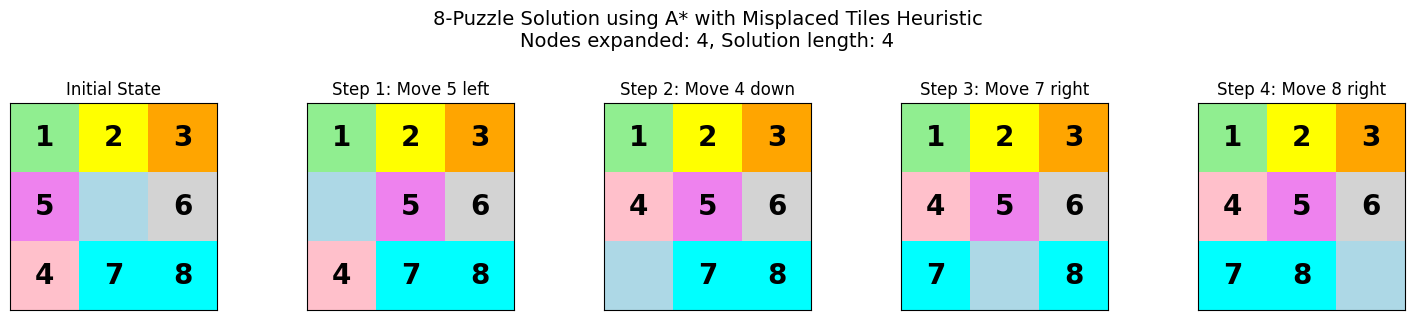


Solving with Manhattan Distance Heuristic...
Solution found in 4 moves
Nodes expanded: 4
Time taken: 0.0000 seconds

Solution path:
1. Move 5 left
2. Move 4 down
3. Move 7 right
4. Move 8 right


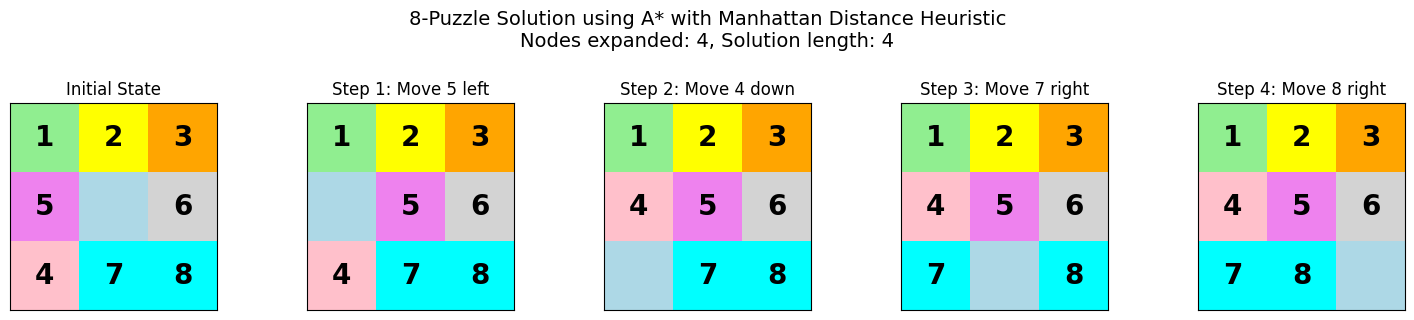

In [2]:
import heapq
import math
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import time

class PuzzleState:
    def __init__(self, board, parent=None, move=None, depth=0):
        self.board = board
        self.parent = parent
        self.move = move  # The move that led to this state
        self.depth = depth  # g(n): cost from start to current node
        self.heuristic = 0  # h(n): heuristic estimate to goal
        
        # Find the position of the blank (0) tile
        for i, row in enumerate(board):
            if 0 in row:
                self.blank_pos = (i, row.index(0))
                break
    
    def __lt__(self, other):
        # Needed for heap comparison when f(n) values are equal
        return (self.depth + self.heuristic) < (other.depth + other.heuristic)
    
    def __eq__(self, other):
        return self.board == other.board
    
    def __hash__(self):
        return hash(tuple(tuple(row) for row in self.board))
    
    def is_goal(self, goal_board):
        return self.board == goal_board
    
    def get_children(self):
        children = []
        row, col = self.blank_pos
        moves = [(0, 1, 'right'), (1, 0, 'down'), (0, -1, 'left'), (-1, 0, 'up')]
        
        for dr, dc, direction in moves:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < 3 and 0 <= new_col < 3:
                new_board = deepcopy(self.board)
                # Swap blank with adjacent tile
                new_board[row][col], new_board[new_row][new_col] = new_board[new_row][new_col], new_board[row][col]
                move_desc = f"Move {new_board[row][col]} {direction}"
                children.append(PuzzleState(new_board, self, move_desc, self.depth + 1))
        
        return children

def h1_misplaced_tiles(current, goal):
    """Heuristic 1: Count of misplaced tiles"""
    count = 0
    for i in range(3):
        for j in range(3):
            if current[i][j] != goal[i][j] and current[i][j] != 0:
                count += 1
    return count

def h2_manhattan_distance(current, goal):
    """Heuristic 2: Sum of Manhattan distances for all tiles"""
    distance = 0
    goal_positions = {}
    
    # Create a dictionary of goal positions for quick lookup
    for i in range(3):
        for j in range(3):
            goal_positions[goal[i][j]] = (i, j)
    
    # Calculate Manhattan distance for each tile
    for i in range(3):
        for j in range(3):
            if current[i][j] != 0:
                goal_i, goal_j = goal_positions[current[i][j]]
                distance += abs(i - goal_i) + abs(j - goal_j)
    
    return distance

def a_star_search(initial, goal, heuristic_func):
    open_set = []
    closed_set = set()
    nodes_expanded = 0
    
    # Initialize the starting state
    initial_state = PuzzleState(initial)
    initial_state.heuristic = heuristic_func(initial, goal)
    
    heapq.heappush(open_set, (initial_state.depth + initial_state.heuristic, initial_state))
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current.is_goal(goal):
            # Reconstruct the path
            path = []
            while current.parent:
                path.append((current.move, current.board))
                current = current.parent
            path.reverse()
            return path, nodes_expanded, len(path)
        
        closed_set.add(current)
        nodes_expanded += 1
        
        for child in current.get_children():
            if child in closed_set:
                continue
            
            child.heuristic = heuristic_func(child.board, goal)
            
            # Check if child is already in open set with higher cost
            in_open = False
            for _, open_state in open_set:
                if open_state == child and (open_state.depth + open_state.heuristic) <= (child.depth + child.heuristic):
                    in_open = True
                    break
            
            if not in_open:
                heapq.heappush(open_set, (child.depth + child.heuristic, child))
    
    return None, nodes_expanded, 0  # No solution found

def visualize_puzzle(board, ax, title=""):
    """Visualize the puzzle board"""
    # Create a custom colormap
    cmap = ListedColormap(['white', 'lightblue', 'lightgreen', 'yellow', 
                          'orange', 'pink', 'violet', 'lightgray', 'cyan'])
    
    # Display the board
    ax.matshow(board, cmap=cmap, vmin=-1, vmax=8)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add tile numbers
    for i in range(3):
        for j in range(3):
            if board[i][j] != 0:
                ax.text(j, i, str(board[i][j]), ha='center', va='center', 
                        fontsize=20, fontweight='bold')

def visualize_solution(initial, goal, path, heuristic_name, nodes_expanded, solution_length):
    """Visualize the entire solution path"""
    n_steps = len(path)
    if n_steps == 0:
        print("Initial state is already the goal state!")
        return
    
    # Calculate grid size for subplots
    cols = min(5, n_steps + 1)
    rows = math.ceil((n_steps + 1) / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    # Flatten axes array for easier indexing
    if rows > 1 and cols > 1:
        axes = axes.flatten()
    elif rows > 1:
        axes = axes.reshape(-1)
    elif cols > 1:
        axes = axes.reshape(-1)
    
    fig.suptitle(f'8-Puzzle Solution using A* with {heuristic_name}\n'
                f'Nodes expanded: {nodes_expanded}, Solution length: {solution_length}', 
                fontsize=14, y=1.05)
    
    # Plot initial state
    visualize_puzzle(initial, axes[0], "Initial State")
    
    # Plot each step
    for step in range(n_steps):
        move, board = path[step]
        visualize_puzzle(board, axes[step+1], f"Step {step+1}: {move}")
    
    # Hide any empty subplots
    for i in range(n_steps + 1, rows * cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def solve_and_visualize(initial, goal, heuristic_func, heuristic_name):
    print(f"\nSolving with {heuristic_name}...")
    start_time = time.time()
    path, nodes_expanded, solution_length = a_star_search(initial, goal, heuristic_func)
    elapsed_time = time.time() - start_time
    
    if path is None:
        print("No solution found!")
        return
    
    print(f"Solution found in {solution_length} moves")
    print(f"Nodes expanded: {nodes_expanded}")
    print(f"Time taken: {elapsed_time:.4f} seconds")
    
    # Print the moves
    print("\nSolution path:")
    for i, (move, _) in enumerate(path, 1):
        print(f"{i}. {move}")
    
    # Visualize
    visualize_solution(initial, goal, path, heuristic_name, nodes_expanded, solution_length)

# Goal state
goal_state = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 0]
]

# Test cases
test_cases = {
    "Easy": [
        [1, 2, 3],
        [4, 5, 6],
        [7, 0, 8]
    ],
    "Medium": [
        [1, 2, 3],
        [5, 0, 6],
        [4, 7, 8]
    ],
    "Hard": [
        [0, 1, 3],
        [4, 2, 5],
        [7, 8, 6]
    ],
    "Very Hard": [
        [8, 1, 3],
        [4, 0, 2],
        [7, 6, 5]
    ]
}

# Select a test case to run
current_test = "Medium"  # Change this to "Easy", "Medium", "Hard", or "Very Hard"
initial_state = test_cases[current_test]

print(f"Solving {current_test} test case:")
for row in initial_state:
    print(row)

# Solve with both heuristics
solve_and_visualize(initial_state, goal_state, h1_misplaced_tiles, "Misplaced Tiles Heuristic")
solve_and_visualize(initial_state, goal_state, h2_manhattan_distance, "Manhattan Distance Heuristic")